In [ ]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
from random import choice, random, randint
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from time import time
import os

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchsummary import summary
import torch.nn.functional as F

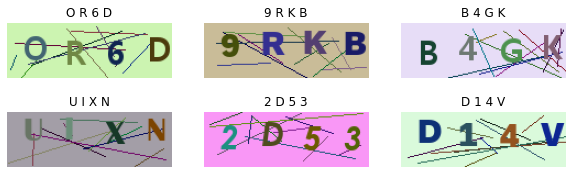

In [ ]:
# CARACTERES = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
CARACTERES = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
N_CLASSES = len(CARACTERES)
N_DIGITOS = 4
CHAR2IDX = {c: v for v, c in enumerate(CARACTERES)}
IDX2CHAR = {v: c for v, c in enumerate(CARACTERES)}

fonts_dir = '/content/drive/MyDrive/Colab Notebooks/CAPTCHA-RECOGNIZER/fonts'
fontes = [str(f) for f in pathlib.Path(fonts_dir).glob('*')]

def cor(tipo):
    min, max = (0, 150) if tipo == 'escura' else (150, 255)
    return (randint(min, max), randint(min, max), randint(min, max))

def criar_imagem(_imgw=150, _imgh=50):
    font_size = 30
    img_pil = Image.new('RGB', (_imgw, _imgh), color=cor('clara'))
    draw = ImageDraw.Draw(img_pil)
    for _ in range(10):
        draw.line([randint(0, _imgw), randint(0, _imgh), randint(0, _imgw), randint(0, _imgh)], fill=cor('escura'), width=1)

    letras = []
    fonte = ImageFont.truetype(choice(fontes), size=font_size)

    for k in range(N_DIGITOS):
        letra = choice(CARACTERES)
        while letra in letras:
            letra = choice(CARACTERES)
        letras.append(letra)
        draw.text((k*(_imgw/4)+15, randint(0, _imgh-font_size-15)), letra, font=fonte, fill=cor('escura'))
    
    return img_pil, letras

plt.figure(figsize=(10, 3))

for k in range(2*3):
    plt.subplot(2, 3, k+1)
    img_pil, caracts = criar_imagem(_imgw=150, _imgh=50)
    plt.imshow(img_pil)
    plt.axis(('off'))
    plt.title(' '.join(caracts))

plt.show()

---
# Criando o Dataset

In [ ]:
!rm -r train_images/* && rm -r test_images/*

rm: cannot remove 'test_images/*': No such file or directory


In [ ]:
if (not(os.path.exists('train_images'))):
    os.mkdir('train_images')

if (not(os.path.exists('test_images'))):
    os.mkdir('test_images')

IMGW, IMGH = 150, 50

for _ in tqdm(range(25000), ncols=60):
    img_pil, img_caract = criar_imagem(IMGW, IMGH)
    img_pil.save(f'train_images/{"".join(img_caract)}.jpg')

for _ in tqdm(range(1000), ncols=60):
    img_pil, img_caract = criar_imagem(IMGW, IMGH)
    img_pil.save(f'test_images/{"".join(img_caract)}.jpg')

100%|██████████████████| 1000/1000 [00:02<00:00, 406.96it/s]


---
# Classe Dataset

img_tensor.shape: torch.Size([3, 50, 150]), target_tensor.shape: torch.Size([36])
tensor([0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
['P', '9', '7', 'N']


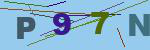

In [ ]:
class Char_Dataset(Dataset):

    def __init__(self, dataset_path, n_classes):
        self.n_classes = n_classes
        self.images = images = [[str(l), str(l)[len(dataset_path)+1:-4]] for l in pathlib.Path(dataset_path).glob('*jpg')]
        self.transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        self.inv_transformer = transforms.Compose([
            transforms.Normalize(mean=(-1., -1., -1.), std=(2., 2., 2.)),
            transforms.ToPILImage()
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):

        img_path, img_caract = self.images[index]
        img_indices = [CHAR2IDX[c] for c in img_caract]
        img_tensor = self.transformer(np.array(Image.open(img_path)))

        target_tensor = torch.zeros((self.n_classes))
        for k, ind in enumerate(img_indices):
            target_tensor[ind] = (4-k)

        return img_tensor, target_tensor

dataset = Char_Dataset('train_images', len(CHAR2IDX))
img_tensor, target_tensor = choice(dataset)

print (f'img_tensor.shape: {img_tensor.shape}, target_tensor.shape: {target_tensor.shape}')
print (target_tensor)

def pegar_letras_do_(_tensor):
    _tensor = _tensor.detach().cpu().numpy()
    indices = [[k,int(v)] for k, v in enumerate(_tensor)]
    indices = sorted([[k,v] for k,v in indices], key=lambda item:item[1], reverse=True)[:4]
    indices = np.array(indices)[:,0]
    letras = [IDX2CHAR[i] for i in indices]
    return letras

print (pegar_letras_do_(target_tensor))

img_pil = dataset.inv_transformer(img_tensor)
img_pil

---
# Classe Modelo

In [ ]:
class Modelo(nn.Module):

    def __init__(self, n_canais, n_classes, imgw, imgh):
        super(Modelo, self).__init__()
        self.n_classes = n_classes
        self.n_canais = n_canais
        self.imgw = imgw
        self.imgh = imgh
        self.n_neuronios = -1

        self.architecture = [
            ['Conv2d', (1, 1), 3],
            ['Maxpool', 2],
            ['Conv2d', (1, 1), 5],
            ['Maxpool', 2],
            ['Conv2d', (1, 1), 3],
            ['Conv2d', (1, 1), 5],
            ['Maxpool', 2],
            ['Flatten'],
            ['Linear', -1, 4096],
            ['LeakyReLU'],
            ['Linear', 4096, -1]
        ]

        self.camadas = []
        for k, camada in enumerate(self.architecture):
            self.camadas.append(self.criar_camada(k, camada))
            if (camada[0] == 'Flatten'):
                self.calcular_n_neuronios()
        
        self.net = nn.Sequential(*self.camadas)
    
    def calcular_n_neuronios(self):
        model_ = nn.Sequential(*self.camadas)
        input = torch.rand((1, 3, self.imgh, self.imgw))
        output = model_(input)
        self.n_neuronios = output.shape[-1]

    def criar_camada(self, k, camada):
        tipo = camada[0]
        if (tipo == 'Conv2d'):
            return nn.Sequential(
                nn.Conv2d(in_channels=3 if k == 0 else self.n_canais, out_channels=self.n_canais, kernel_size=camada[2], stride=camada[1]),
                nn.BatchNorm2d(num_features=self.n_canais),
                nn.LeakyReLU()
            )
        
        if (tipo == 'Maxpool'):
            return nn.MaxPool2d(kernel_size=camada[1], stride=2)
        
        if (tipo == 'Flatten'):
            return nn.Flatten()
        
        if (tipo == 'LeakyReLU'):
            return nn.LeakyReLU()
        
        if (tipo == 'Linear'):
            input = self.n_neuronios if camada[1] == -1 else camada[1]
            output = self.n_classes if camada[2] == -1 else camada[2]
            return nn.Linear(in_features=input, out_features=output)
    
    def forward(self, x):
        return self.net(x)

model = Modelo(n_canais=16, n_classes=len(CHAR2IDX), imgw=IMGW, imgh=IMGH)

input = torch.rand((1, 3, IMGH, IMGW))
output = model(input)
print (f'output.shape: {output.shape}')
print (output)

output.shape: torch.Size([1, 36])
tensor([[ 0.0874,  0.1766, -0.1965,  0.5733,  0.0634,  0.4150, -0.2021, -0.0041,
          0.0429, -0.1100, -0.3202,  0.2586,  0.2231, -0.3299,  0.0464,  0.3507,
          0.0658,  0.1888,  0.1601, -0.1882,  0.3387,  0.3311, -0.1025,  0.2009,
         -0.1679,  0.2805, -0.2317,  0.3581, -0.0446,  0.3248, -0.3519,  0.5310,
          0.1329,  0.2182, -0.0574, -0.2744]], grad_fn=<AddmmBackward0>)


---
# Funções úteis para o treinamento

In [ ]:
def validar(_model: Modelo, _loss_fn, _dataloader, _device):
    _model.eval()
    target_values, predict_values = [], []
    with torch.no_grad():
        test_loss = 0
        for imgs_tensor, target_tensor in _dataloader:
            imgs_tensor, target_tensor = imgs_tensor.to(_device), target_tensor.to(_device)
            predict_tensor = _model(imgs_tensor)
            loss = _loss_fn(predict_tensor, target_tensor)
            test_loss += loss.item()
    
    return test_loss

def salvar_checkpoint(_model, _epoch):
    checkpoint = {
        'state_dict': _model.state_dict(),
        'n_canais': _model.n_canais,
        'n_classes': _model.n_classes,
        'CHAR2IDX': CHAR2IDX,
        'IDX2CHAR': IDX2CHAR,
        'epocas': epoch
    }
    torch.save(checkpoint, 'model.pth')

loss_fn = nn.MSELoss()

test_dataset = Char_Dataset('test_images', N_CLASSES)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
validar(model, loss_fn, test_dataloader, torch.device('cpu'))

831.7224318385124

---
# Treinamento

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CARACTERES = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
N_CLASSES = len(CARACTERES)
N_DIGITOS = 4
CHAR2IDX = {c: v for v, c in enumerate(CARACTERES)}
IDX2CHAR = {v: c for v, c in enumerate(CARACTERES)}
IMGW = 150
IMGH = 50
N_CANAIS = 64
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
EPOCHS = 75

train_dataset = Char_Dataset('train_images', N_CLASSES)
test_dataset = Char_Dataset('test_images', N_CLASSES)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = Modelo(n_canais=N_CANAIS, n_classes=N_CLASSES, imgw=IMGW, imgh=IMGH)
loss_fn = nn.MSELoss()
model.to(DEVICE)
loss_fn.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

results = []
cabecalho = ['epoch', 'train_loss', 'test_loss', 'tempo']
print (' | '.join([str(c).center(15) for c in cabecalho]))

for epoch in range(EPOCHS):

    inicio = time()
    train_loss = 0
    model.train()

    for imgs_tensor, target_tensor in train_dataloader:
        
        imgs_tensor, target_tensor = imgs_tensor.to(DEVICE), target_tensor.to(DEVICE)
        
        optimizer.zero_grad()
        predict_tensor = model(imgs_tensor)
        loss = loss_fn(predict_tensor, target_tensor)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss
    test_loss = validar(model, loss_fn, test_dataloader, DEVICE)
    scheduler.step()

    tempo = time() - inicio
    vetor = [epoch, train_loss, test_loss, tempo]
    results.append(vetor)
    salvar_checkpoint(model, epoch)
    
    print (' | '.join([str(round(v, 3)).center(15) for v in vetor]))

     epoch      |    train_loss   |    test_loss    |      tempo     
       0        |     1104.164    |      32.474     |      81.149    
       1        |     407.952     |      7.322      |      74.979    
       2        |     113.279     |       3.38      |      74.194    
       3        |      71.017     |      2.606      |      73.852    
       4        |      50.308     |      1.908      |      73.601    
       5        |      36.887     |      1.464      |      73.643    
       6        |      28.488     |      1.559      |      73.406    
       7        |      23.18      |      1.076      |      74.458    
       8        |      19.846     |       0.99      |      73.605    
       9        |      17.079     |      0.997      |      73.787    
       10       |      14.493     |      0.912      |      73.639    
       11       |      13.537     |      0.932      |      74.882    
       12       |      12.23      |      0.764      |      74.504    
       13       |   

---
# Resultados

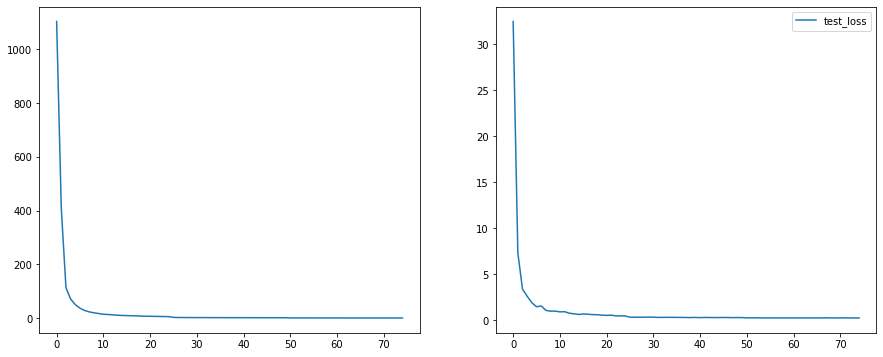

In [ ]:
results = np.array(results)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(results[:,0], results[:,1], label='train_loss')
plt.subplot(1, 2, 2)
plt.plot(results[:,0], results[:,2], label='test_loss')
plt.legend()
plt.show()

---
# Validação final

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/CAPTCHA-RECOGNIZER/model.pth', map_location=torch.device('cpu'))
print ('epocas: ', checkpoint['epocas'])
model = Modelo(64, N_CLASSES, IMGW, IMGH)
model.load_state_dict(checkpoint['state_dict'])

epocas:  74


<All keys matched successfully>

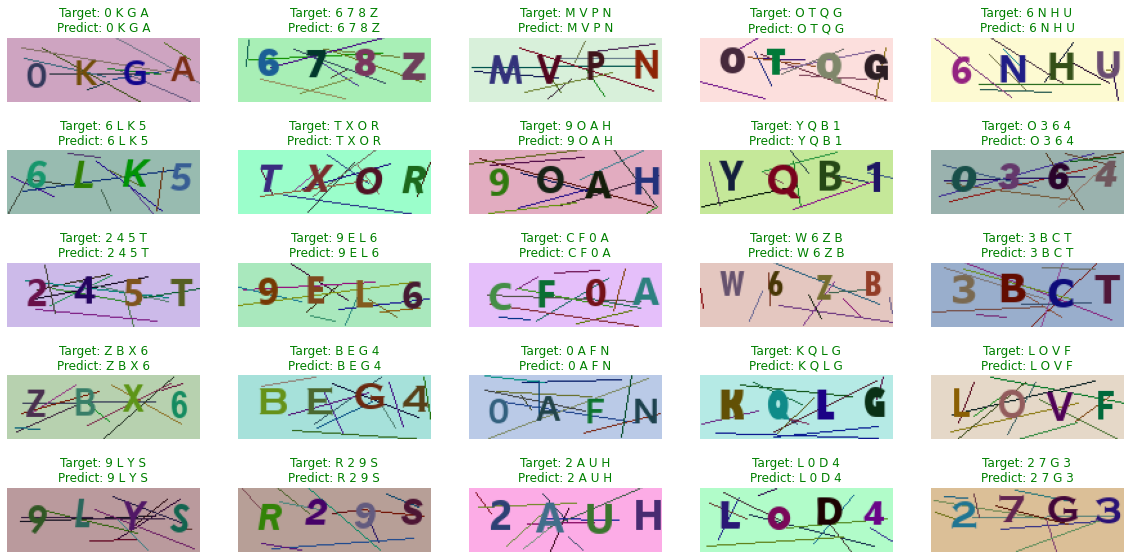

In [ ]:
img_pil, img_caract = criar_imagem()

transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])

def inferir(img_pil, _model, _transformer):
    _model.eval()
    with torch.no_grad():
        img_tensor = _transformer(np.array(img_pil))
        predict_tensor = _model(img_tensor.unsqueeze(0))
    
    predict_tensor = predict_tensor[0].detach().cpu().numpy()
    
    letras = []
    for k in [4, 3, 2, 1]:
        indice_maior_valor = abs(k - predict_tensor).argmin(0)
        letras.append(IDX2CHAR[indice_maior_valor])
    
    return letras

plt.figure(figsize=(20, 10))
for k in range(5*5):
    plt.subplot(5, 5, k+1)
    img_pil, target_caract = criar_imagem()

    predict_caract = inferir(img_pil, model, transformer)

    predict_caract, target_caract = " ".join(predict_caract), " ".join(target_caract)
    texto_titulo = f'Target: {target_caract}\nPredict: {predict_caract}'
    
    plt.imshow(img_pil)
    plt.title(texto_titulo, c='green' if predict_caract == target_caract else 'red')
    plt.axis('off')

plt.show()